## Goal of this notebook:

- Calculate gaze-in-world velocity
- Filter it


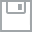
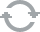
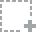
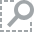
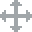
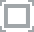
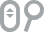
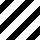
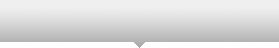
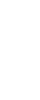
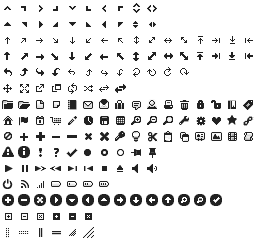
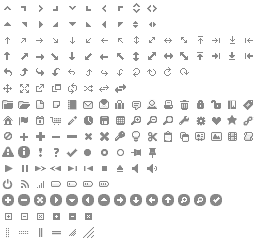
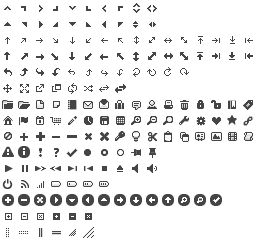
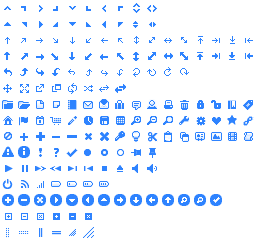
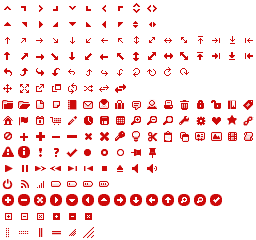
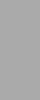
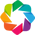
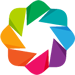

In [67]:
from __future__ import division

import PerformParser as pp
import pandas as pd
import numpy as np
from scipy import signal as sig
import performFun as pF
import catchE1Funs as e1

import bokeh.plotting as bkP
import bokeh.models as bkM
from bokeh.palettes import Spectral6
import filterpy as fP

import Quaternion as qu

bkP.output_notebook() 

#%pylab inline


In [68]:
import notebook
E = notebook.nbextensions.EnableNBExtensionApp()
E.enable_nbextension('usability/rubberband/main')

In [69]:
fileTime = '2015-11-24-21-26'
expCfgName = "gd_pilot_B.cfg"
sysCfgName = "PERFORMVR.cfg"

In [70]:
filePath = "../Data/exp/" + fileTime + "/"
fileName = "exp_data-" + fileTime + ".dict"

In [71]:
s1 = pp.readPerformDict(filePath + fileName)
expConfig = pF.createExpCfg(filePath + expCfgName)
sysConfig = pF.createSysCfg(filePath + sysCfgName)
s1ProcData = e1.initProcessedData(s1)

s1TrialInfo = e1.initTrialInfo(s1)

Loading experiment config file: ../Data/exp/2015-11-24-21-26/gd_pilot_B.cfg
Experiment config file parsed correctly
Loading system config file: ../Data/exp/2015-11-24-21-26/PERFORMVR.cfg
System config file parsed correctly


This cycGazeInWorld data is no good!  I expected an normalized gaze vector.

# Calculate cyc GIW from EIH 
Gaze EIW is not correct, so lets calcuate gaze direction from the eye in head angles.

### Convert view quaternion to rotation matrix

In [72]:
import Quaternion as qu

viewRotMat_fr_mRow_mCol = [qu.Quat(np.array(q,dtype=np.float))._quat2transform() for q in s1.viewQuat.values]    
np.shape(viewRotMat_fr_mRow_mCol)

(51087, 3, 3)

Lets take a look at the cycEyeInHead values at the beginning of a trial and make sure that they make sense.

### Here is one way to get GIW values - from EIH + rotation matrix

In [73]:

cycEyeInHead_fr_XYZ = s1.cycEyeInHead.values
cycEyeInHead_fr_XYZ[:,0] = np.negative(cycEyeInHead_fr_XYZ[:,0])

cycGazeInWorld_fr_XYZ = np.array([ np.dot(cycEyeInHead_fr_XYZ[fr].T,viewRotMat_fr_mRow_mCol[fr]) 
     for fr in range(len(cycEyeInHead_fr_XYZ))])

cycGazeInWorld_fr_XYZ.shape


(51087, 3)

### Lets store this new cyc GIW data in the dataframe

In [74]:
s1[('cycNewGIW','X')] = pd.Series( cycGazeInWorld_fr_XYZ[:,0] )
s1[('cycNewGIW','Y')] = pd.Series( cycGazeInWorld_fr_XYZ[:,1] )
s1[('cycNewGIW','Z')] = pd.Series( cycGazeInWorld_fr_XYZ[:,2] )

In [75]:
s1['cycGIWVelocity'] = pF.calcAngularVelocity(s1['cycNewGIW'].values, s1['frameTime']) 
#s1.cycGIWVelocity = pF.calcAngularVelocity(s1['cycNewGIW'].values, s1.eyeTimeStamp);

### For playing with gaze velocity timestamp

In [76]:
pF.calcAngularVelocity(s1['cycNewGIW'].values, s1.eyeTimeStamp)

array([  0.00000000e+00,   3.15572708e-10,   3.77074980e-09, ...,
         3.60886759e-08,   3.80060810e-08,   2.42324838e-08])

### Note that I do a linear interpolation over NAN values.  This has not been verified as a smart thing to do.

In [82]:
s1['cycGIWVelocity'] = s1['cycGIWVelocity'].interpolate()

## Filter data

### A butterworth filter

The following few cells were an attempt at a butterworth.  However, I haven't done the work to set the cutoff accurately, yet.  So, I'll just save this for later.

In [83]:
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
%matplotlib notebook
from scipy.fftpack import fft

In [84]:
notNanIdx = ~np.isnan(s1.cycGIWVelocity)
y  = np.array(s1.cycGIWVelocity,dtype=np.float)
t = s1.frameTime.values # time vector
Fs = 75.0;  # sampling rate


Ts = 1.0/Fs; # sampling interval
n = len(t) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range

Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(int(n/2))]

<IPython.core.display.Javascript object>


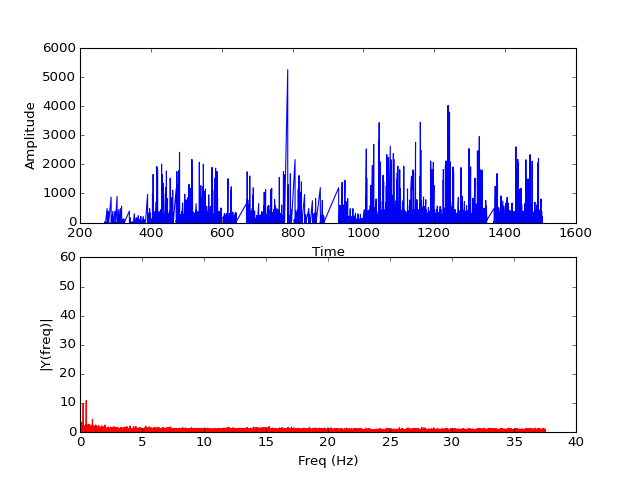

In [85]:

fig, ax = plt.subplots(2, 1)
ax[0].plot(t,y)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(frq,abs(Y),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')


In [86]:
from scipy.signal import butter, filtfilt, freqz

def butter_lowpass_filter(data, cutoff, fs, order=5):
    #b, a = butter_lowpass(cutoff, fs, order=order)
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False,output='ba')
    #y = lfilter(b, a, data)
    y = filtfilt(b,a,data)
    return y


### Plot the whole trial

### Plot a single trial

In [119]:
Fs = 75.0;  # sampling rate

order = 4
fs = 75.0       # sample rate, Hz
cutoff = 18  # desired cutoff frequency of the filter, Hz

filtVel_fr = np.array(butter_lowpass_filter(s1['cycGIWVelocity'], cutoff, fs, order),dtype=np.float)
s1ProcData['cycGIWVelocityFilt'] = filtVel_fr




In [120]:
trialNum = 20

gbTrials = s1.groupby('trialNumber')

trialFrames  = gbTrials.get_group(trialNum).index

p1 = pF.timeSeries(frametime_fr = gbTrials.get_group(trialNum)['frameTime'].values,
                   yDataList = [gbTrials.get_group(trialNum)['cycGIWVelocity'].values,
                                s1ProcData['cycGIWVelocityFilt'][trialFrames].values],
                   events_fr = gbTrials.get_group(trialNum)['eventFlag'].values,
                   yLabel='gaze velocity',
                   legendLabels = ['raw','filt'],
                   yLims = [0,150],
                   plotHeight=350)
bkP.show(p1)


### Plot the whole timeseries.  This is a bit much.  Slow.

In [87]:

# time_fr = s1.frameTime.values
# events_fr = s1.eventFlag
# Fs = 75.0;  # sampling rate

# order = 2
# fs = 75.0       # sample rate, Hz
# cutoff = 30  # desired cutoff frequency of the filter, Hz

# filtVel_fr = np.array(butter_lowpass_filter(s1['cycGIWVelocity'], cutoff, fs, order),dtype=np.float)
# s1ProcData['cycGIWVelocityFilt'] = filtVel_fr
# trialStarts = [gr['frameTime'].values[0] for name , gr in s1.groupby('trialNumber')]

# p1 = pF.timeSeries(frametime_fr = time_fr,
#                    yDataList = [filtVel_fr, rawVel_fr],
#                    events_fr = events_fr.values, 
#                    trialsStarts_tr = trialStarts,
#                    yLabel='velocity (d/s)',
#                    legendLabels = ['filtered','raw'],
#                    yLims = [0,100],
#                    plotHeight=400)

# bkP.show(p1)
